# P-219 => Hourly Energy Consumption Forecast

    The hourly power consumption data comes from PJM's website and are in megawatts (MW).

    ● Build model, split the last year into a test set and train model on remaining data.
    ● Forecast for next 30 days using model build.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing data set
df = pd.read_excel(r"C:\Users\rohit\Downloads\Project\PJMW_MW_Hourly.xlsx", index_col=0, parse_dates=True)
df['Years'] = df.index.year
s = (df.index.month * 100 + df.index.day - 320) % 1300
df['Season'] = pd.cut(s, [0, 300, 600, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])
df['Hours'] = df.index.hour
df

,PJMW_MW,Years,Season,Hours
Datetime,,,,
2002-12-31 01:00:00,5077.0,2002,Winter,1
2002-12-31 02:00:00,4939.0,2002,Winter,2
2002-12-31 03:00:00,4885.0,2002,Winter,3
2002-12-31 04:00:00,4857.0,2002,Winter,4
2002-12-31 05:00:00,4930.0,2002,Winter,5
...,...,...,...,...
2018-01-01 20:00:00,8401.0,2018,Winter,20
2018-01-01 21:00:00,8373.0,2018,Winter,21
2018-01-01 22:00:00,8238.0,2018,Winter,22


## Data preprocessing and EDA

In [3]:
df['Season'].fillna('Summer', inplace= True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   PJMW_MW  143206 non-null  float64 
 1   Years    143206 non-null  int64   
 2   Season   143206 non-null  category
 3   Hours    143206 non-null  int64   
dtypes: category(1), float64(1), int64(2)
memory usage: 4.5 MB


In [5]:
df.describe(include='all')

,PJMW_MW,Years,Season,Hours
count,143206.000000,143206.000000,143206,143206.000000
unique,NaN,NaN,4,NaN
top,NaN,NaN,Spring,NaN
freq,NaN,NaN,37266,NaN
mean,5602.375089,2009.918691,NaN,11.501620
std,979.142872,4.730344,NaN,6.921789
min,487.000000,2002.000000,NaN,0.000000
25%,4907.000000,2006.000000,NaN,6.000000
50%,5530.000000,2010.000000,NaN,12.000000
75%,6252.000000,2014.000000,NaN,18.000000


In [6]:
df.isna().sum()

PJMW_MW    0
Years      0
Season     0
Hours      0
dtype: int64

In [7]:
# IQR
Q1 = np.percentile(df['PJMW_MW'], 25, interpolation='midpoint')
Q3 = np.percentile(df['PJMW_MW'], 75, interpolation='midpoint')

IQR = Q3 - Q1
print('Q1 : ', Q1)
print('Q3 : ', Q3)
print('IQR :', IQR)

Q1 :  4907.0
Q3 :  6252.0
IQR : 1345.0


In [8]:
out_low = df[df['PJMW_MW'] < (Q1 - 1.5*IQR)]
out_low

,PJMW_MW,Years,Season,Hours
Datetime,,,,
2003-05-29 00:00:00,487.0,2003,Spring,0
2012-04-01 13:00:00,2878.0,2012,Spring,13
2012-04-01 14:00:00,2721.0,2012,Spring,14
2012-04-01 15:00:00,2663.0,2012,Spring,15
2012-04-01 16:00:00,2574.0,2012,Spring,16
2012-04-01 17:00:00,2586.0,2012,Spring,17
2012-04-01 18:00:00,2600.0,2012,Spring,18
2012-04-01 19:00:00,2630.0,2012,Spring,19
2012-04-01 23:00:00,2690.0,2012,Spring,23


In [9]:
ol = out_low['PJMW_MW'].values
ol = list(ol)
ol

[487.0, 2878.0, 2721.0, 2663.0, 2574.0, 2586.0, 2600.0, 2630.0, 2690.0, 2553.0]

In [10]:
out_high = df[df['PJMW_MW'] > (Q3 + 1.5*IQR)]
out_high

,PJMW_MW,Years,Season,Hours
Datetime,,,,
2002-07-29 18:00:00,8270.0,2002,Summer,18
2002-07-22 17:00:00,8300.0,2002,Summer,17
2003-01-23 18:00:00,8296.0,2003,Winter,18
2003-01-23 19:00:00,8431.0,2003,Winter,19
2003-01-23 20:00:00,8437.0,2003,Winter,20
...,...,...,...,...
2018-01-02 21:00:00,8563.0,2018,Winter,21
2018-01-02 22:00:00,8322.0,2018,Winter,22
2018-01-01 19:00:00,8328.0,2018,Winter,19


In [11]:
oh = out_high['PJMW_MW'].values
oh = list(oh)
oh

[8270.0,
 8300.0,
 8296.0,
 8431.0,
 8437.0,
 8333.0,
 8417.0,
 8478.0,
 8366.0,
 8297.0,
 8307.0,
 8598.0,
 8574.0,
 8490.0,
 8289.0,
 8409.0,
 8279.0,
 8362.0,
 8298.0,
 8289.0,
 8321.0,
 8322.0,
 8280.0,
 8336.0,
 8361.0,
 8391.0,
 8300.0,
 8395.0,
 8608.0,
 8719.0,
 8566.0,
 8547.0,
 8546.0,
 8505.0,
 8299.0,
 8330.0,
 8498.0,
 8546.0,
 8546.0,
 8444.0,
 8294.0,
 8376.0,
 8411.0,
 8301.0,
 8569.0,
 8516.0,
 8550.0,
 8605.0,
 8546.0,
 8470.0,
 8320.0,
 8402.0,
 8393.0,
 8480.0,
 8595.0,
 8564.0,
 8566.0,
 8298.0,
 8327.0,
 8515.0,
 8625.0,
 8707.0,
 8656.0,
 8493.0,
 8274.0,
 8277.0,
 8352.0,
 8347.0,
 8278.0,
 8308.0,
 8403.0,
 8392.0,
 8589.0,
 8721.0,
 8823.0,
 8797.0,
 8695.0,
 8356.0,
 8498.0,
 8664.0,
 8623.0,
 8340.0,
 8404.0,
 8400.0,
 8319.0,
 8287.0,
 8383.0,
 8381.0,
 8304.0,
 8338.0,
 8435.0,
 8501.0,
 8523.0,
 8316.0,
 8317.0,
 8424.0,
 8310.0,
 8275.0,
 8352.0,
 8485.0,
 8536.0,
 8589.0,
 8465.0,
 8485.0,
 8382.0,
 8453.0,
 8294.0,
 8324.0,
 8278.0,
 8488.0,
 8742.0,
 

In [12]:
outliers = ol + oh
outliers

[487.0,
 2878.0,
 2721.0,
 2663.0,
 2574.0,
 2586.0,
 2600.0,
 2630.0,
 2690.0,
 2553.0,
 8270.0,
 8300.0,
 8296.0,
 8431.0,
 8437.0,
 8333.0,
 8417.0,
 8478.0,
 8366.0,
 8297.0,
 8307.0,
 8598.0,
 8574.0,
 8490.0,
 8289.0,
 8409.0,
 8279.0,
 8362.0,
 8298.0,
 8289.0,
 8321.0,
 8322.0,
 8280.0,
 8336.0,
 8361.0,
 8391.0,
 8300.0,
 8395.0,
 8608.0,
 8719.0,
 8566.0,
 8547.0,
 8546.0,
 8505.0,
 8299.0,
 8330.0,
 8498.0,
 8546.0,
 8546.0,
 8444.0,
 8294.0,
 8376.0,
 8411.0,
 8301.0,
 8569.0,
 8516.0,
 8550.0,
 8605.0,
 8546.0,
 8470.0,
 8320.0,
 8402.0,
 8393.0,
 8480.0,
 8595.0,
 8564.0,
 8566.0,
 8298.0,
 8327.0,
 8515.0,
 8625.0,
 8707.0,
 8656.0,
 8493.0,
 8274.0,
 8277.0,
 8352.0,
 8347.0,
 8278.0,
 8308.0,
 8403.0,
 8392.0,
 8589.0,
 8721.0,
 8823.0,
 8797.0,
 8695.0,
 8356.0,
 8498.0,
 8664.0,
 8623.0,
 8340.0,
 8404.0,
 8400.0,
 8319.0,
 8287.0,
 8383.0,
 8381.0,
 8304.0,
 8338.0,
 8435.0,
 8501.0,
 8523.0,
 8316.0,
 8317.0,
 8424.0,
 8310.0,
 8275.0,
 8352.0,
 8485.0,
 8536.0,
 8

In [13]:
df['PJMW_MW'] = df['PJMW_MW'].replace(to_replace=outliers, value=5602.375089)

In [14]:
df.describe()

,PJMW_MW,Years,Hours
count,143206.000000,143206.000000,143206.000000
mean,5588.316737,2009.918691,11.501620
std,956.732269,4.730344,6.921789
min,2922.000000,2002.000000,0.000000
25%,4907.000000,2006.000000,6.000000
50%,5530.000000,2010.000000,12.000000
75%,6234.000000,2014.000000,18.000000
max,8269.000000,2018.000000,23.000000


## Visualizations

In [15]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 200
sns.set_style('darkgrid')

Text(0, 0.5, 'PJMW (in MW)')

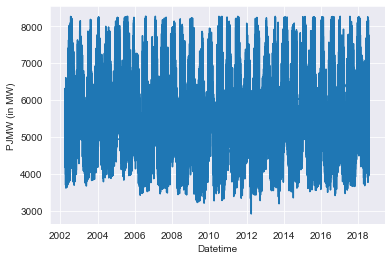

In [16]:
plt.plot(df['PJMW_MW'])
plt.xlabel('Datetime')
plt.ylabel('PJMW (in MW)')

<Axes: xlabel='PJMW_MW', ylabel='Density'>

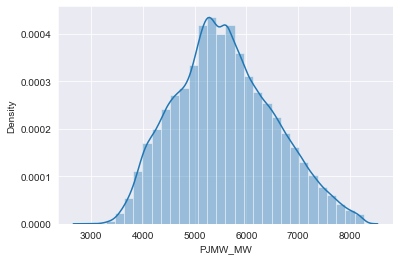

In [17]:
sns.distplot(df['PJMW_MW'], bins=30)

### From histogram we can say that the data is normally distributed

<Axes: xlabel='PJMW_MW'>

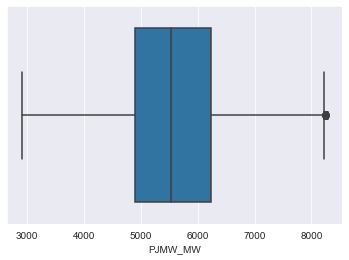

In [18]:
sns.boxplot(df['PJMW_MW'])

<Axes: xlabel='Datetime', ylabel='PJMW_MW'>

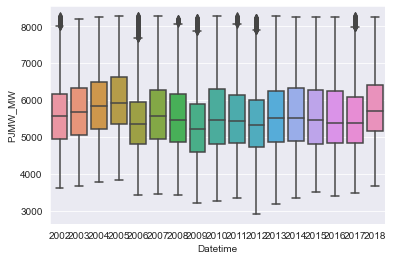

In [19]:
sns.boxplot(x=df.index.year, y=df['PJMW_MW'])

<Axes: xlabel='Datetime', ylabel='PJMW_MW'>

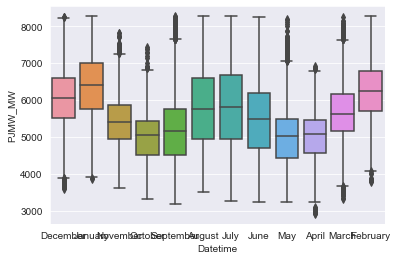

In [20]:
sns.boxplot(x=df.index.month_name(), y=df['PJMW_MW'])

<Axes: xlabel='Datetime', ylabel='PJMW_MW'>

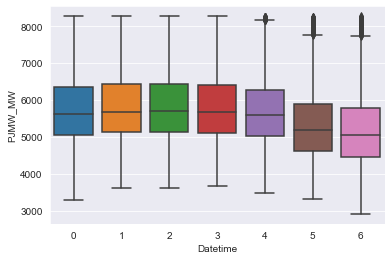

In [21]:
sns.boxplot(x=df.index.day_of_week, y=df['PJMW_MW'])

<Axes: xlabel='Datetime', ylabel='PJMW_MW'>

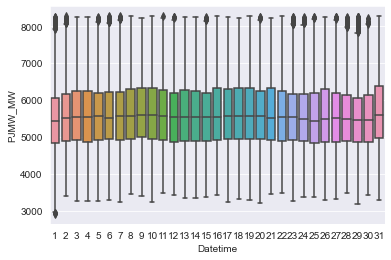

In [22]:
sns.boxplot(x=df.index.day, y=df['PJMW_MW'])

In [23]:
from statsmodels.tsa.stattools import adfuller

In [24]:
p = adfuller(df['PJMW_MW'])[1]
p

0.0

#### According the p-value, the dataset is stationary as the p value is less than alpha value (0.05).

## Spliting of data

In [25]:
train_data = df[df['Years'] != 2018]
test_data = df[df['Years'] == 2018]

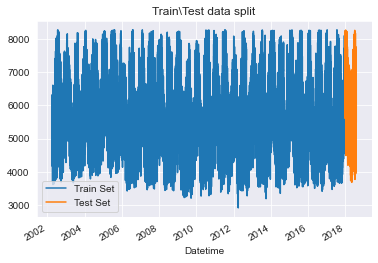

In [26]:
fig, ax = plt.subplots()
train_data['PJMW_MW'].plot(ax=ax, label='Train data', title='Train\Test data split')
test_data['PJMW_MW'].plot(ax=ax, label='Test data')
ax.legend(['Train Set', 'Test Set'])

In [27]:
df.head(2)

,PJMW_MW,Years,Season,Hours
Datetime,,,,
2002-12-31 01:00:00,5077.0,2002,Winter,1
2002-12-31 02:00:00,4939.0,2002,Winter,2


In [28]:
df_2 = df.drop(columns=['Years', 'Season', 'Hours'])
df_2['Hour'] = df_2.index.hour
df_2['Day'] = df_2.index.day
df_2['Month'] = df_2.index.month
df_2['Quarter'] = df_2.index.quarter
df_2['Year'] = df_2.index.year
df_2

,PJMW_MW,Hour,Day,Month,Quarter,Year
Datetime,,,,,,
2002-12-31 01:00:00,5077.000000,1,31,12,4,2002
2002-12-31 02:00:00,4939.000000,2,31,12,4,2002
2002-12-31 03:00:00,4885.000000,3,31,12,4,2002
2002-12-31 04:00:00,4857.000000,4,31,12,4,2002
2002-12-31 05:00:00,4930.000000,5,31,12,4,2002
...,...,...,...,...,...,...
2018-01-01 20:00:00,5602.375089,20,1,1,1,2018
2018-01-01 21:00:00,5602.375089,21,1,1,1,2018
2018-01-01 22:00:00,8238.000000,22,1,1,1,2018


In [29]:
train = df_2[df_2['Year'] != 2018]
test = df_2[df_2['Year'] == 2018]

In [30]:
df_2.columns

Index(['PJMW_MW', 'Hour', 'Day', 'Month', 'Quarter', 'Year'], dtype='object')

In [31]:
x_train = train[['Hour', 'Day', 'Month', 'Quarter', 'Year']]
x_test = test[['Hour', 'Day', 'Month', 'Quarter', 'Year']]
y_train = train[['PJMW_MW']]
y_test = test[['PJMW_MW']]

# Model building

### XGBRegressor model

In [32]:
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error

In [33]:
xgb_model = XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.03, max_depth= 5, min_child_weight= 4, 
                        n_estimators= 500, nthread= 4, objective= 'reg:linear', subsample= 0.7)
xgb_model.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_test, y_test)], early_stopping_rounds=50, verbose=False)

[13:34:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, nthread=4, num_parallel_tree=None,
             objective='reg:linear', ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

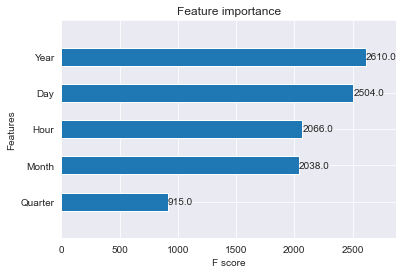

In [34]:
plot_importance(xgb_model, height=0.5)

In [35]:
# Prediction on train data
pred_xgb = xgb_model.predict(x_train)
rmse_xgb = np.sqrt(mean_squared_error(y_train, pred_xgb))
rmse_xgb

528.5164423157087

In [36]:
# Prediction on test data
pred_xgb1 = xgb_model.predict(x_test)
rmse_xgb1 = np.sqrt(mean_squared_error(y_test, pred_xgb1))
rmse_xgb1

695.3311077487632

In [37]:
# Prediction on entire data
pred_xgb2 = xgb_model.predict(df_2.iloc[:,1:])
rmse_xgb2 = np.sqrt(mean_squared_error(df_2['PJMW_MW'], pred_xgb2))
rmse_xgb2

535.3985021321051

In [38]:
final_pred = xgb_model.predict(df_2.iloc[:,1:])
final_pred = pd.DataFrame(final_pred, columns=['Predicted'], index=df_2.index)
final_pred

,Predicted
Datetime,
2002-12-31 01:00:00,5348.272461
2002-12-31 02:00:00,5222.743652
2002-12-31 03:00:00,5189.927246
2002-12-31 04:00:00,5186.069824
2002-12-31 05:00:00,5222.630859
...,...
2018-01-01 20:00:00,6058.583008
2018-01-01 21:00:00,6053.282227
2018-01-01 22:00:00,5897.927734


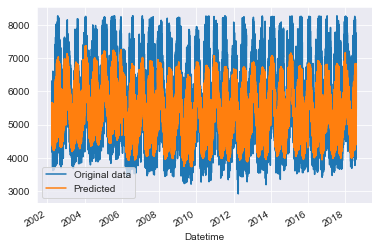

In [39]:
fig, ax = plt.subplots()
df_2['PJMW_MW'].plot(ax=ax, label='Original data')
final_pred.plot(ax=ax, label='Predicted')
plt.legend(['Original data', 'Predicted'])

In [40]:
from sklearn.metrics import r2_score
score = r2_score(df_2['PJMW_MW'], final_pred['Predicted'])
score

0.686832639594176

# Forecast for next 30 days

In [41]:
from datetime import datetime
datetime_str = '08/03/18 00:00:00'
datetime_object = datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S')
print(datetime_object)

2018-08-03 00:00:00


In [42]:
index_of_forecast = pd.date_range(datetime_object + pd.DateOffset(days=1), periods = 30*24, freq='H')
index_of_forecast

DatetimeIndex(['2018-08-04 00:00:00', '2018-08-04 01:00:00',
               '2018-08-04 02:00:00', '2018-08-04 03:00:00',
               '2018-08-04 04:00:00', '2018-08-04 05:00:00',
               '2018-08-04 06:00:00', '2018-08-04 07:00:00',
               '2018-08-04 08:00:00', '2018-08-04 09:00:00',
               ...
               '2018-09-02 14:00:00', '2018-09-02 15:00:00',
               '2018-09-02 16:00:00', '2018-09-02 17:00:00',
               '2018-09-02 18:00:00', '2018-09-02 19:00:00',
               '2018-09-02 20:00:00', '2018-09-02 21:00:00',
               '2018-09-02 22:00:00', '2018-09-02 23:00:00'],
              dtype='datetime64[ns]', length=720, freq='H')

In [43]:
fut_in = pd.DataFrame(index=index_of_forecast)
fut_in['Hour'] = fut_in.index.hour
fut_in['Day'] = fut_in.index.day
fut_in['Month'] = fut_in.index.month
fut_in['Quarter'] = fut_in.index.quarter
fut_in['Year'] = fut_in.index.year
fut_in

,Hour,Day,Month,Quarter,Year
2018-08-04 00:00:00,0,4,8,3,2018
2018-08-04 01:00:00,1,4,8,3,2018
2018-08-04 02:00:00,2,4,8,3,2018
2018-08-04 03:00:00,3,4,8,3,2018
2018-08-04 04:00:00,4,4,8,3,2018
...,...,...,...,...,...
2018-09-02 19:00:00,19,2,9,3,2018
2018-09-02 20:00:00,20,2,9,3,2018
2018-09-02 21:00:00,21,2,9,3,2018
2018-09-02 22:00:00,22,2,9,3,2018


In [44]:
forecast = xgb_model.predict(fut_in)
forecast = pd.DataFrame(forecast, columns=['Forecast'], index=fut_in.index)
forecast

,Forecast
2018-08-04 00:00:00,5247.145996
2018-08-04 01:00:00,4882.066895
2018-08-04 02:00:00,4610.585449
2018-08-04 03:00:00,4443.253906
2018-08-04 04:00:00,4400.838867
...,...
2018-09-02 19:00:00,5925.501953
2018-09-02 20:00:00,5902.507324
2018-09-02 21:00:00,5890.136719
2018-09-02 22:00:00,5670.508301


<Axes: >

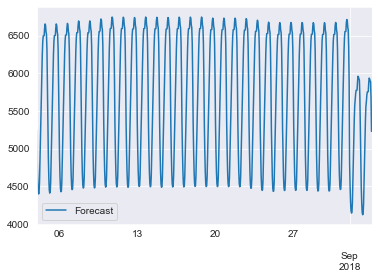

In [45]:
forecast.plot()

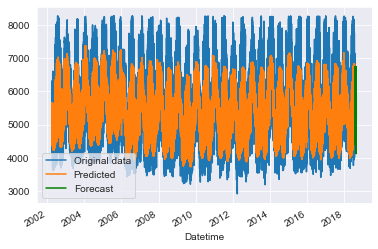

In [46]:
fig, ax = plt.subplots()
df['PJMW_MW'].plot(ax=ax, label='Original data')
final_pred.plot(ax=ax, label='Predicted')
forecast.plot(ax=ax, label='Forecast', color='green')
plt.legend(['Original data', 'Predicted', 'Forecast'])

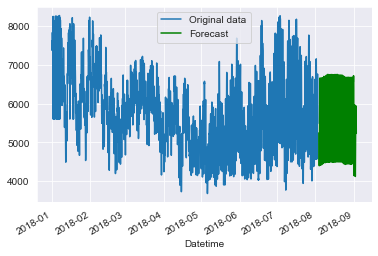

In [47]:
fig, ax = plt.subplots()
y_test['PJMW_MW'].plot(ax=ax, label='Original data')
forecast.plot(ax=ax, label='Forecast', color='green')
plt.legend(['Original data', 'Forecast'])

# Deployment

In [48]:
import pickle

In [49]:
# Saving model
filename = 'Energy usage Forecast.pkl'
pickle.dump(xgb_model, open(filename, 'wb'))

In [50]:
# Loading model
loaded_model = pickle.load(open(filename, 'rb'))

In [53]:
fut_in.head(1)

,Hour,Day,Month,Quarter,Year
2018-08-04,0,4,8,3,2018


In [55]:
forecast.head(1)

,Forecast
2018-08-04,5247.145996


In [54]:
input_data = (0,4,8,3,2018)

# input data as np array
input_as_array = np.asarray(input_data)

# reshape input  np array
input_reshaped = input_as_array.reshape(1,-1)

# Predict output
predicted_output = loaded_model.predict(input_reshaped)
predicted_output

array([5247.146], dtype=float32)